# Instance Segmentation Demo 2: Additive Manufacturing dataset

This is a short demo of the instance segmentation utility of the improved AtomAI model. The instance segmentation works using watershed segmentation, connected components and rules based on geometry.


The data contains optical micrographs of H13 and Inconel 625 steels along with manually marked image-maps.

In [ ]:
!pip install git+https://github.com/Pragalbhv/atomai # install the latest version from sourcefrom sklearn.metrics import classification_report

  Cloning https://github.com/Pragalbhv/atomai to /tmp/pip-req-build-0a24ur8c
  Running command git clone --filter=blob:none --quiet https://github.com/Pragalbhv/atomai /tmp/pip-req-build-0a24ur8c
  Resolved https://github.com/Pragalbhv/atomai to commit a3b7fc07d8e1f912400822d9262cdb0cc0182199
  Preparing metadata (setup.py) ... done


In [ ]:
# import all necessay libraries.
import pickle as pkl
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

import atomai as aoi
from atomai.utils import create_lattice_mask, extract_patches_
from atomai.transforms import datatransform

Import the instance segmentation utilities required by running the following command:

In [ ]:
from atomai.utils.instance_seg_utils import *

Download [AM_dataset.pkl](https://drive.google.com/file/d/1s2_9Mmha7q6CcM5LRTyE1EbpbEE4Er5k/view?usp=sharing) and place it in your colab files. DO NOT use gdown or wget, as the file size is large, and it will not download correctly.**

**: This behavior is due to gdown and wget's integration with google colab, and not with the dataset



In [ ]:
with open('AM_dataset.pkl', 'rb') as f:
    data = pkl.load(f)

Set the images and the masks.

In [ ]:
images=data['images']

In [ ]:
masks=data['masks']

The following code squeezes the channels of the various classes. Additionally, some images contain a scale bar. This scale bar is irrelevant to the task at hand, thus we replace the 'scale-bar' class by average background intensity.

In [ ]:
images_=[]
labels_=[]
for im,msk in zip(images,masks):
    im_arr=np.array([im])
    msk_arr=np.array([msk])
    im_arr,msk_arr=squeeze_channels2(im_arr,msk_arr)
    im_,msk_=replace_class_and_average(im_arr[0],msk_arr[0])

    images_.append(im_)
    labels_.append(msk_)

images_=np.array(images_,dtype="object")
labels_=np.array(labels_,dtype="object")



We shall split off the test data, then create patches of the rest of the image, label pairs and perform data augmentation.

In [ ]:
images_train, images_test, masks_train, masks_test = get_train_test(images_,labels_)

In [ ]:
def patch_base(images,labels):


    images_full, labels_full = extract_patches_(images[0], labels[0], patch_size=256, num_patches=500, random_state=42)

    for i in range(1,len(images)):
        images_all, labels_all = extract_patches_(images[i], labels[i], patch_size=256, num_patches=500, random_state=42)
        images_full=np.concatenate((images_full,images_all))
        labels_full=np.concatenate((labels_full,labels_all))
    return images_full,labels_full



In [ ]:
images_all,labels_all=patch_base(images_train,masks_train)

In [ ]:
ch = 4

In [ ]:
# Define image distortion/noise parameters
zoom = 1.1 # zoom factor
poisson = [30, 40] # P noise range (scaled units)
gauss = [20, 100] # G noise range (scaled units)
blur = [1, 40] # Blurring range (scaled units)
contrast = [5, 14] # contrast range (< 10 is brighter, > 10 is darker)
salt_and_pepper = [1, 10] # min/max amount of salted/peppered pixels (scaled units)
# Run the augmentor
imaug = datatransform(
    n_channels=ch, dim_order_in='channel_last', dim_order_out='channel_first',
    gauss_noise=gauss, poisson_noise=poisson, salt_and_pepper=salt_and_pepper,
    contrast=contrast, blur=blur, zoom=zoom, rotation=True,
    squeeze_channels=False, seed=42)
images_all, labels_all = imaug.run(images_all, labels_all)

print(images_all.shape, labels_all.shape)


(4500, 1, 256, 256) (4500, 256, 256)


For the instance segmentation model, we need only two classes porosity and background. Thus we map both gas-induced:1 and lack of fusion:2 to porosity:1.

In [ ]:
images_all2=[]
labels_all2=[]
for im,msk in zip(images_all,labels_all):
    im_arr=np.array([im])
    msk_arr=np.array([msk])

    msk_arr[0][msk_arr[0]==2]=1

    images_all2.append(im_arr[0])
    labels_all2.append(msk_arr[0])

In [ ]:
images_all=np.array(images_all2)
labels_all=np.array(labels_all2)

In [ ]:
images, images_val, labels, labels_val = train_test_split(
    images_all, labels_all, test_size=0.2, random_state=42)

We create the Tmapping of gas-induced:1 and lack of fusion:2 to porosity:1. Hwoever, for test we will save the actual labels for the test data  as well, and will use it to verify the performance of the final model

In [ ]:
images_test_all2=[]
labels_test_all2=[]
labels_test_3class=[]


for im,msk in zip(images_test,masks_test ):
    im_arr=np.array([im])
    msk_arr=np.array([msk])

    labels_test_3class.append(msk_arr[0].copy())
    msk_arr[0][msk_arr[0]==2]=1
    images_test_all2.append(im_arr[0])
    labels_test_all2.append(msk_arr[0])

images_test=np.array(images_test_all2,dtype='object')
labels_test=np.array(labels_test_all2,dtype='object')
labels_test_3class=np.array(labels_test_3class,dtype='object')


In [ ]:
np.unique(labels_test_3class[0])#actual labels

array([0., 1., 2.])

In [ ]:
np.unique(labels[0])

array([0., 1.])

Let's plot some of the training data:

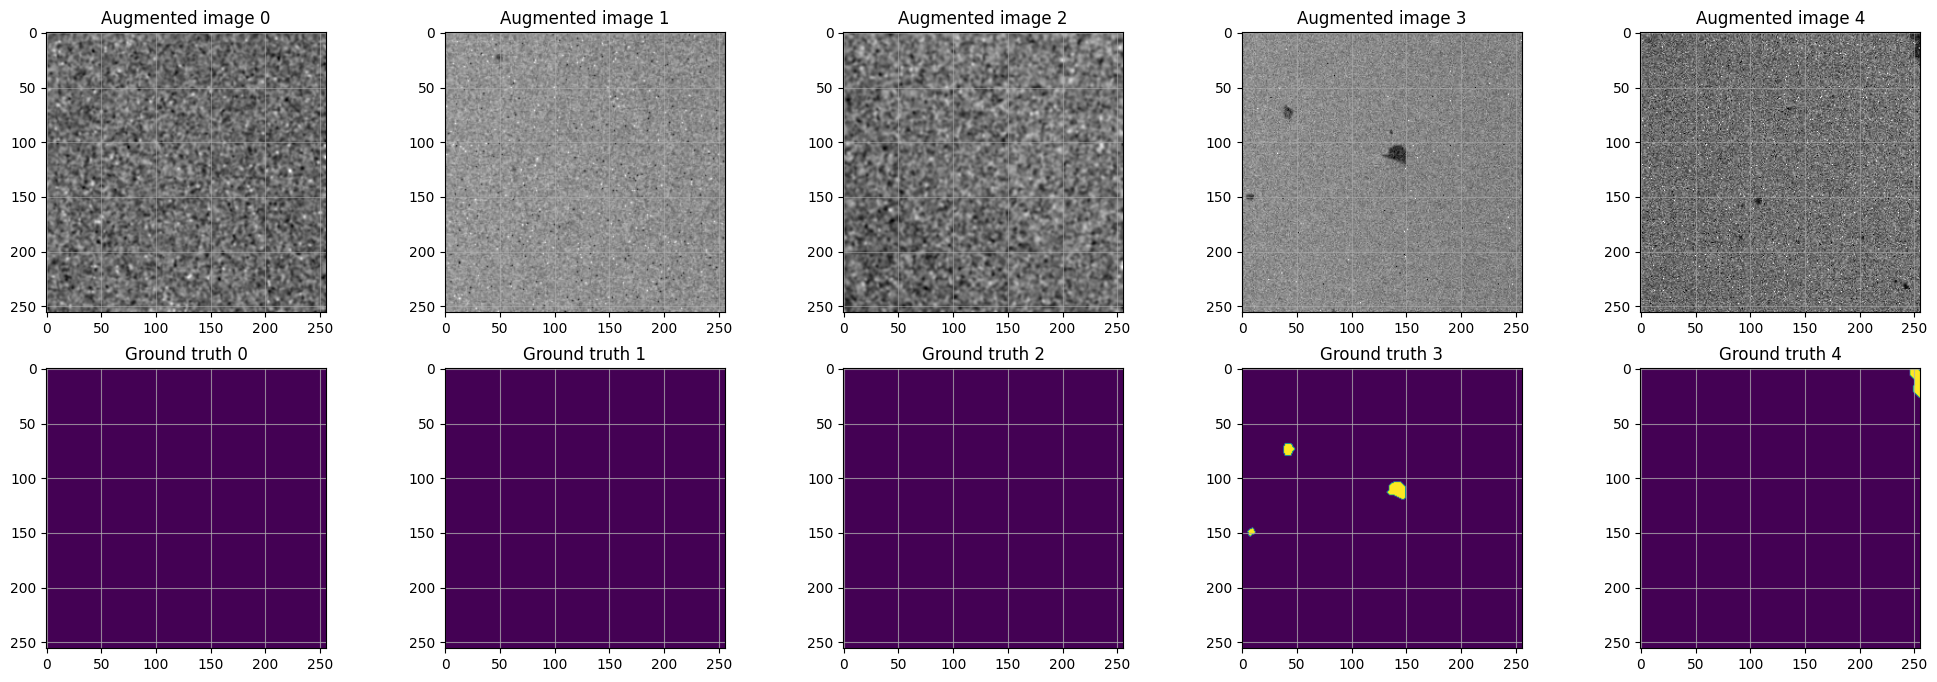

In [ ]:
n = 5
k=1
n = n + 1
fig = plt.figure( figsize=(30, 8))
for i in range(1, n):
    ax = fig.add_subplot(2, n, i)
    ax.imshow(images[i-1+k,0,:,:], cmap='gray')
    ax.set_title('Augmented image ' + str(i-1) )
    ax.grid(alpha = 0.5)
    ax = fig.add_subplot(2, n, i+n)
    if labels.shape[1] == 1:
        ax.imshow(labels[i-1+k, 0], cmap='gray', interpolation='Gaussian')
    else:
        ax.imshow(labels[i-1+k], interpolation='Gaussian')
    ax.set_title('Ground truth ' + str(i-1))
    ax.grid(alpha=0.75)

Initialize a nodel for semantic segmentation. Note that the number of classes is 1. We will perform sematic segmentation and then transform the semantic maps to instance segmentation maps using the watershed algorithm

In [ ]:
model = aoi.models.Segmentor(nb_classes=1)

In [ ]:
print(model.net)

Unet(
  (c1): ConvBlock(
    (block): Sequential(
      (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.01)
      (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (c2): ConvBlock(
    (block): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.01)
      (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): LeakyReLU(negative_slope=0.01)
      (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (c3): ConvBlock(
    (block): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.01)
      (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   

The model uses the previously developed features of early stopping and automatic thresholding. We can also schedule learning rates.

In [ ]:
lr_rates=[1e-3,1e-4,1e-5]
lr_rates=np.repeat(lr_rates,20)
#1e-3 for 20 iters, 1e-4 for next 20, 1e-5 for the rest

/shared/CV_at_PV/atomai_ES/atomai/utils/preproc.py:64: UserWarning: Adding a channel dimension of 1 to training labels
  warnings.warn(
/shared/CV_at_PV/atomai_ES/atomai/utils/preproc.py:69: UserWarning: Adding a channel dimension of 1 to test labels
  warnings.warn(


Updating ES model @ Epoch 1/5000 ... Training loss: 0.5089 ... Test loss: 0.1793 ... Train Accuracy: 0.5595 ... Test Accuracy: 0.8147 ... GPU memory usage: 4532/20470
Updating ES model @ Epoch 2/5000 ... Training loss: 0.0955 ... Test loss: 0.039 ... Train Accuracy: 0.8396 ... Test Accuracy: 0.8493 ... GPU memory usage: 4534/20470
Updating ES model @ Epoch 3/5000 ... Training loss: 0.0282 ... Test loss: 0.0173 ... Train Accuracy: 0.8457 ... Test Accuracy: 0.8523 ... GPU memory usage: 4534/20470
Updating ES model @ Epoch 4/5000 ... Training loss: 0.0153 ... Test loss: 0.0103 ... Train Accuracy: 0.849 ... Test Accuracy: 0.8632 ... GPU memory usage: 4534/20470
Updating ES model @ Epoch 5/5000 ... Training loss: 0.013 ... Test loss: 0.0085 ... Train Accuracy: 0.8205 ... Test Accuracy: 0.8507 ... GPU memory usage: 4534/20470
Updating ES model @ Epoch 6/5000 ... Training loss: 0.0086 ... Test loss: 0.0072 ... Train Accuracy: 0.8566 ... Test Accuracy: 0.8442 ... GPU memory usage: 4534/20470
U

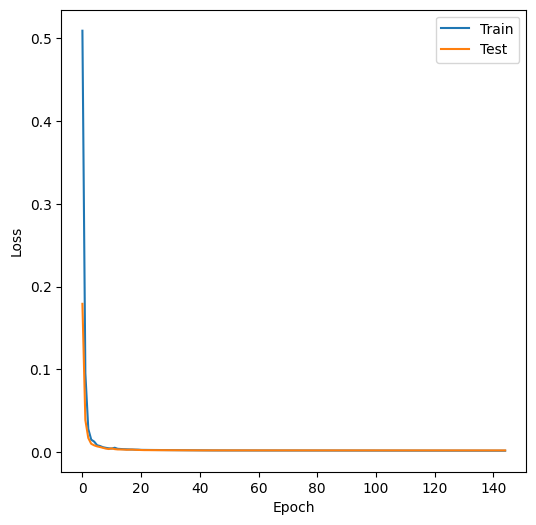

Calculating Automatic Threshold
Batch 900/900
900 images were decoded in approximately 2.6223 seconds


In [ ]:
model.fit(images, labels, images_val, labels_val, # training data
         training_cycles=5000, compute_accuracy=True, batch_size=16, swa=False, filename='Seg2Inst_comb',
         ES=True, patience=100,tolerance=1e-4,verbose=True,auto_thresh=True, full_epoch=True,
         lr_scheduler=lr_rates)

In [ ]:
preds_probs=[]
preds=[]

for im in images_test:
    pred_m=model.predict(im)[0][0]
    print(pred_m.shape)

    preds_probs.append(pred_m)
    preds.append(convert_preds_to_classes(pred_m))

Performing auto-thresh prediction
Batch 1/1
1 image was decoded in approximately 0.1343 seconds
(1536, 2048, 1)
Performing auto-thresh prediction
Batch 1/1
1 image was decoded in approximately 0.13 seconds
(1536, 2048, 1)
Performing auto-thresh prediction
Batch 1/1
1 image was decoded in approximately 0.0292 seconds
(480, 640, 1)


We use the following function that provides watershed markers, geometrical properties and polygons based on the prediction probabilities of the semantic segmentation module.




  Returns:

      - final_preds (list): List of NumPy arrays, each representing the final watershed markers for an image.
      - properties (list): List of Pandas DataFrames, each containing geometric properties for regions in an image.
      - polygons (list): List of NumPy arrays, each representing the approximated polygons for regions in an image.

In [ ]:
final_preds, properties, polygons = pred_to_prop_masks(images_test,one_vs_all_preds(preds, class_id=1))

In [ ]:
properties[0]#look at the geometric properties visible as a DataFrame

,area,perimeter,equivalent_diameter,major_axis_length,minor_axis_length,eccentricity,orientation,solidity
1,19.0,16.449747,4.918491,8.890776,2.859805,0.946855,0.314996,0.863636
2,11.0,11.207107,3.742410,8.399515,1.723021,0.978734,1.319718,0.733333
3,135.0,40.142136,13.110581,13.580749,12.657958,0.362326,1.464411,0.978261
4,3.0,3.414214,1.954410,2.309401,1.333333,0.816497,0.785398,1.000000
5,36.0,21.071068,6.770275,8.794346,5.340756,0.794477,-1.095008,0.923077
...,...,...,...,...,...,...,...,...
106,8.0,7.414214,3.191538,3.464102,2.738613,0.612372,-0.785398,1.000000
107,7.0,6.828427,2.985411,3.703280,2.138090,0.816497,-0.785398,1.000000
108,7.0,7.242641,2.985411,3.648666,2.505808,0.726871,-1.380543,0.875000
109,4.0,4.000000,2.256758,2.000000,2.000000,0.000000,-0.785398,1.000000


We shall now implemenet the following rule based on geometrical proerties:

if $f(a, s) \leq 0.042$ and $f(d, a) \leq 0.491$ then the porosity is lack-of-fusion otherwise its gas induced.

 Here, $a$, $s$ and $d$ represent the major axis length, solidity and the equivalent diameter of the instance, respectively. Further, function $f$ represent the transformation $f(x,y) = \frac{xy}{x^2+y^2}$.

In [ ]:
df_fin_list=[]
delta_small=1e-10
for df in properties:
    data=df.copy()
    data['f(major_axis_length,solidity)']=(data['major_axis_length']*data['solidity'] / (data['major_axis_length']**2 + data['solidity']**2+delta_small))
    data['f(equivalent_diameter,major_axis_length)']=(data['equivalent_diameter']*data['major_axis_length'] / (data['equivalent_diameter']**2 + data['major_axis_length']**2+delta_small))
    data['class']=((data['f(major_axis_length,solidity)']<= 0.04144560918211937) & (data['f(equivalent_diameter,major_axis_length)']<= 0.49079978466033936)).astype(int)
    df_fin_list.append(data)



In [ ]:
df_fin= pd.concat(df_fin_list, axis=0)#concat the Dataframes for visualization

We can now visualize the scatterplot of the instantiated porosities in the space of the geometric properties and view its distribution.

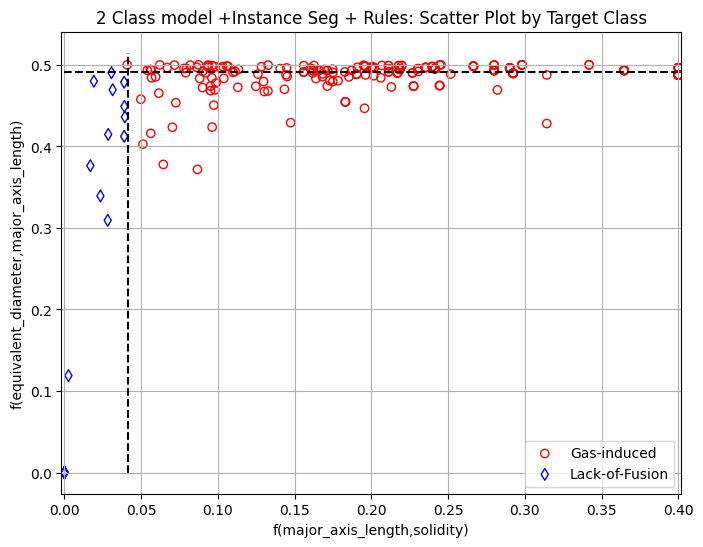

In [ ]:
# Get the top 2 correlated columns (assuming you have correlations pre-computed)
top_cols = ['f(major_axis_length,solidity)','f(equivalent_diameter,major_axis_length)']  # Assuming columns at index 1 and 2 are most correlated

# Scatter plot with different markers for target classes
plt.figure(figsize=(8, 6))

class_data = df_fin[df_fin['class'] == 0]
plt.scatter(class_data[top_cols[0]], class_data[top_cols[1]],marker='o',facecolors='none', edgecolors='r', label='Gas-induced')

class_data = df_fin[df_fin['class'] == 1]
plt.scatter(class_data[top_cols[0]], class_data[top_cols[1]],marker='d',facecolors='none', edgecolors='b', label='Lack-of-Fusion')

plt.hlines(0.49079978466033936,xmin=0, xmax=max(df_fin[top_cols[0]]),linestyles='dashed', color='black', zorder=2)
plt.vlines(0.04144560918211937,ymin=0, ymax=max(df_fin[top_cols[1]]+0.015),linestyles='dashed', color='black', zorder=2)
plt.axis(xmin=-0.002,xmax=0.402)

plt.grid(True)

plt.xlabel(top_cols[0])
plt.ylabel(top_cols[1])
plt.title('2 Class model +Instance Seg + Rules: Scatter Plot by Target Class')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

Let us now look at the classification report:


*   Precision
*   Recall
*   f1-score



In [ ]:
masksf=[]
for i in range(3):
    h,w=final_preds[i].shape
    pl1,pl2=seperate_polygons(polygons[i],df_fin_list[i])
    mask=create_masks_from_polygon_sets(h,w,pl1,pl2)
    masksf.append(squeeze_channels_(mask))

In [ ]:
labels_flat=np.array(flatten_array(labels_test_3class))

In [ ]:
predsf=[ms[0] for ms in masksf]

In [ ]:
predsf_flat=np.array(flatten_array(masksf))


In [ ]:
from sklearn.metrics import classification_report

In [ ]:
print(classification_report(labels_flat,predsf_flat,
                            target_names=['background','gas-induced','lack-of-fusion']))

                precision    recall  f1-score   support

    background       1.00      1.00      1.00   6591754
   gas-induced       0.52      0.85      0.65      3383
lack-of-fusion       0.75      0.76      0.76      3519

      accuracy                           1.00   6598656
     macro avg       0.76      0.87      0.80   6598656
  weighted avg       1.00      1.00      1.00   6598656



We shall now overlay the predictions and compare with the ground truth.

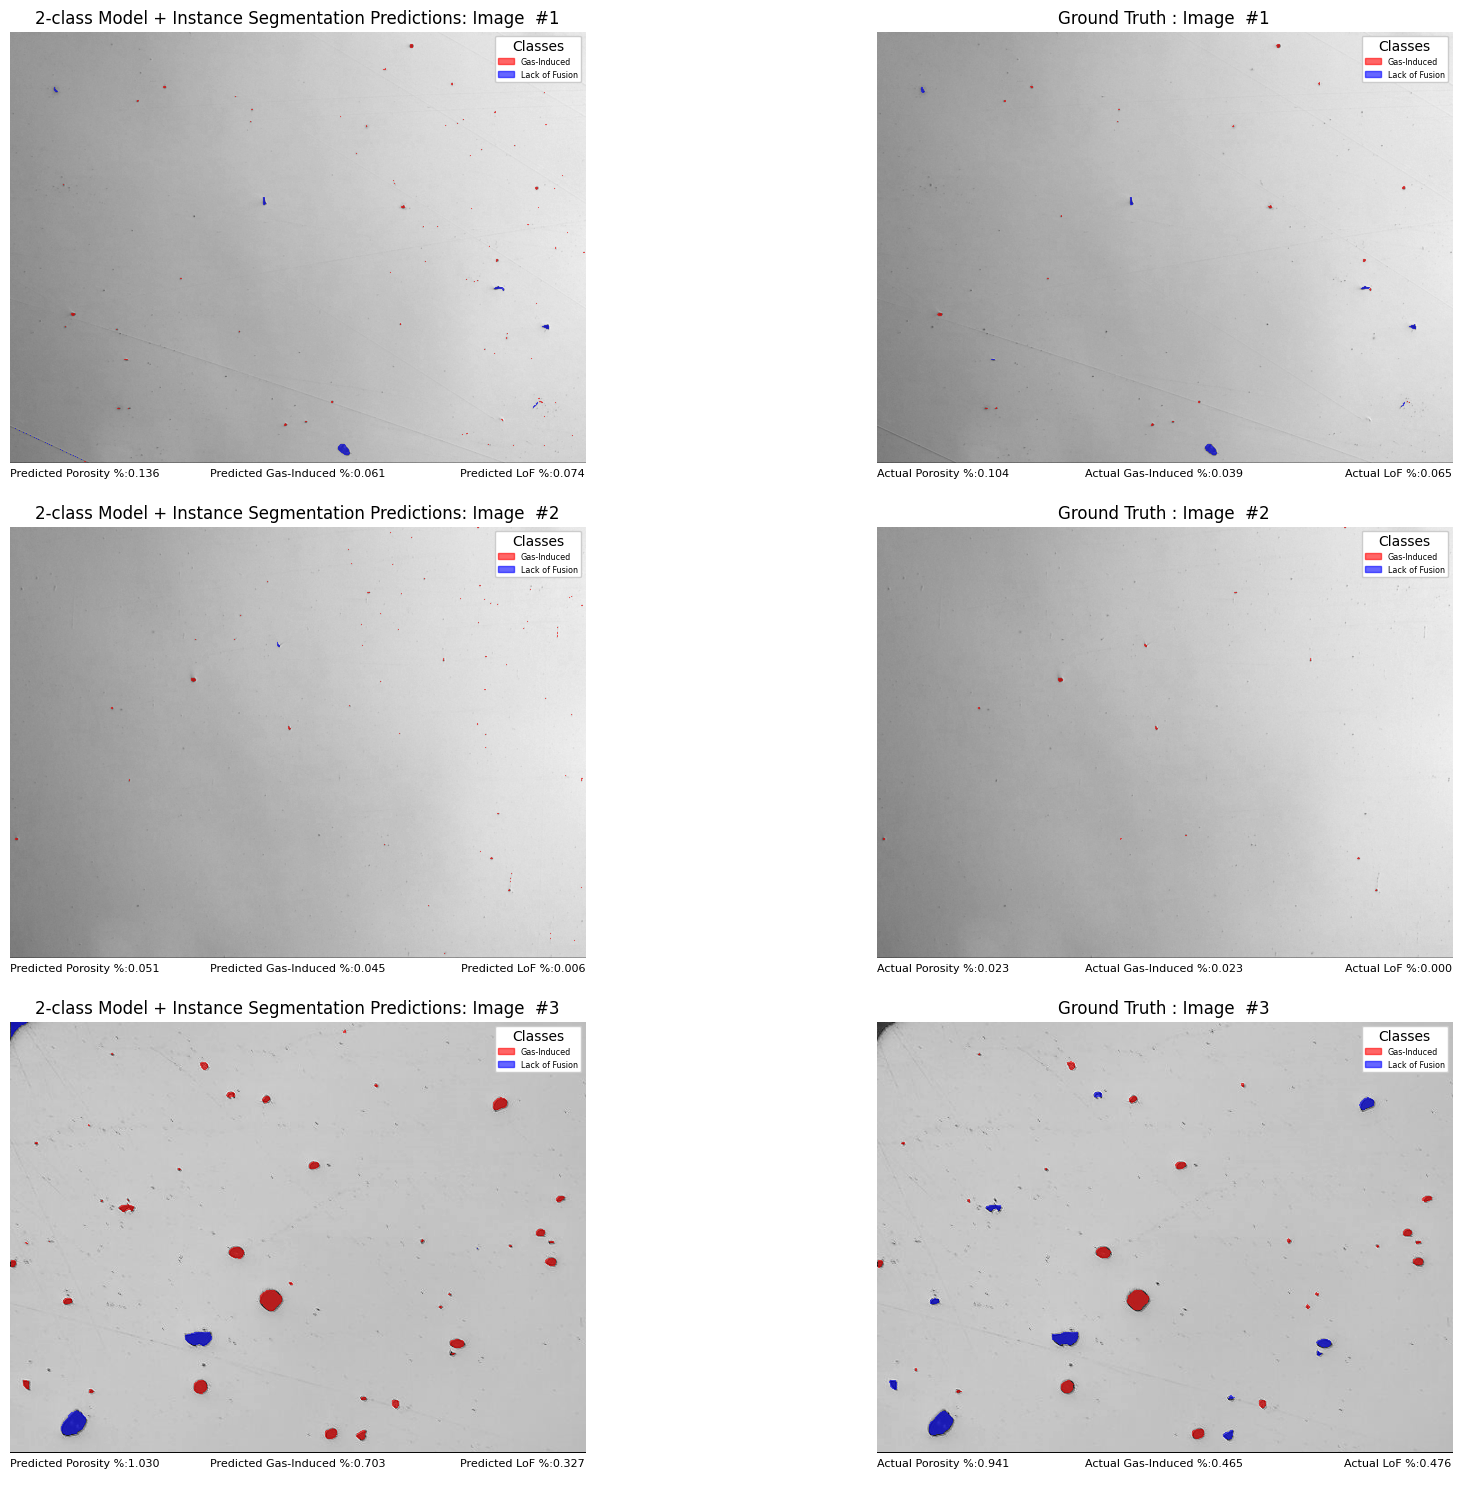

In [ ]:
rows=3
cols=2
# Create figure and axes grid
fig, axes = plt.subplots(rows, cols, figsize=(20, 15))
k=0
# Iterate through the plots
for i in range(3):

    ax = axes[i,0]  # Access the subpl
    ax.axis('off')

    ax.text(0,-0.03, f"Predicted Porosity %:{porosity(predsf[i+k],mode=0):.3f}", size=8, ha="left",
         transform=ax.transAxes)
    ax.text(0.5,-0.03, f"Predicted Gas-Induced %:{porosity(predsf[i+k],mode=1):.3f}", size=8, ha="center",
         transform=ax.transAxes)
    ax.text(1,-0.03, f"Predicted LoF %:{porosity(predsf[i+k],mode=2):.3f}", size=8, ha="right",
         transform=ax.transAxes)
    ax.text(0.5,-0.06, "                                         ", size=20, ha="center",
         transform=ax.transAxes)
    ax.imshow(images_test[i+k],cmap='gray')
    ax=get_im(predsf[i+k],title=f"2-class Model + Instance Segmentation Predictions: Image  #{i+k+1}",ax=ax)




    ax = axes[i,1]  # Access the subpl
    ax.axis('off')
    ax.text(0,-0.03, f"Actual Porosity %:{porosity(labels_test_3class[i+k],mode=0):.3f}", size=8, ha="left",
     transform=ax.transAxes)
    ax.text(0.5,-0.03, f"Actual Gas-Induced %:{porosity(labels_test_3class[i+k],mode=1):.3f}", size=8, ha="center",
         transform=ax.transAxes)
    ax.text(1,-0.03, f"Actual LoF %:{porosity(labels_test_3class[i+k],mode=2):.3f}", size=8, ha="right",
         transform=ax.transAxes)
    ax.text(0.5,-0.06, "                                         ", size=20, ha="center",
         transform=ax.transAxes)
    ax.imshow(images_test[i+k],cmap='gray')
    ax=get_im(labels_test_3class[i+k],title=f"Ground Truth : Image  #{i+k+1}",ax=ax)


# Adjust spacing and show the plots
fig.tight_layout()
plt.show()